# Rating Prediction - Regression 

## 1. Imports 

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from xgboost import XGBRegressor

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load data

In [2]:
project_root = Path.cwd().parent
DATA_DIR = Path(project_root / "data")

with open(DATA_DIR/"all_recipes_clean.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(df.head())
print(df.shape)

                                    title  \
0         Lasagnes végétariennes (facile)   
1            Hachis parmentier végétarien   
2             Curry de légumes végétarien   
3                    Hamburger Végétarien   
4  Tourte de Noël végétarienne de Coralie   

                                                 url  rating  \
0  https://www.marmiton.org/recettes/recette_lasa...     4.8   
1  https://www.marmiton.org/recettes/recette_hach...     4.6   
2  https://www.marmiton.org/recettes/recette_curr...     4.8   
3  https://www.marmiton.org/recettes/recette_hamb...     4.7   
4  https://www.marmiton.org/recettes/recette_tour...     4.6   

                                         ingredients  total_ecv  total_kcal  \
0  [{'ingredient_name': 'tomates', 'quantity': 20...   0.449643  242.400000   
1  [{'ingredient_name': 'poireau', 'quantity': 15...   0.269614  614.366667   
2  [{'ingredient_name': 'carotte', 'quantity': 40...   0.357829  224.000000   
3  [{'ingredient_name': 'oeu

## 3. Keep recipes with rating

In [ ]:
recipes_with_rating = [
    r for r in data
    if r.get("rating") is not None and isinstance(r.get("rating"), (int, float))
]
print("Remaining recipes with rating:", len(recipes_with_rating))

df = pd.DataFrame(recipes_with_rating)
print(df.shape)

Remaining recipes with rating: 1693
(1693, 13)


## 4. Select numeric features

In [4]:
numeric_features = [
    "total_ecv","total_kcal","total_protein","total_fat",
    "avg_ecv","avg_kcal","avg_protein","avg_fat",
    "is_vege"
]

X_num = df[numeric_features].copy()
y = df["rating"]

## 5. Normalize numeric features

In [5]:
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

## 6. Text embedding

In [6]:
model = SentenceTransformer("all-MiniLM-L6-v2")
X_text = model.encode(df["title"].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 53/53 [00:01<00:00, 39.84it/s]


## 7. Build hybrid vector (concat)

In [7]:
X = np.hstack([X_text, X_num_scaled])
print("Final feature shape:", X.shape)

Final feature shape: (1693, 393)


## 8. Define model

In [8]:
model_xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

## 9. Cross-validation (5-fold)

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model_xgb.fit(X_train, y_train)
    preds = model_xgb.predict(X_val)

    mse_scores.append(mean_squared_error(y_val, preds))
    r2_scores.append(r2_score(y_val, preds))

print("MSE:", np.mean(mse_scores), "+/-", np.std(mse_scores))
print("R2 :", np.mean(r2_scores), "+/-", np.std(r2_scores))

MSE: 0.4434006103684808 +/- 0.04400991637814502
R2 : 0.015775504734603964 +/- 0.0650446960831362


## 10. Feature importance 

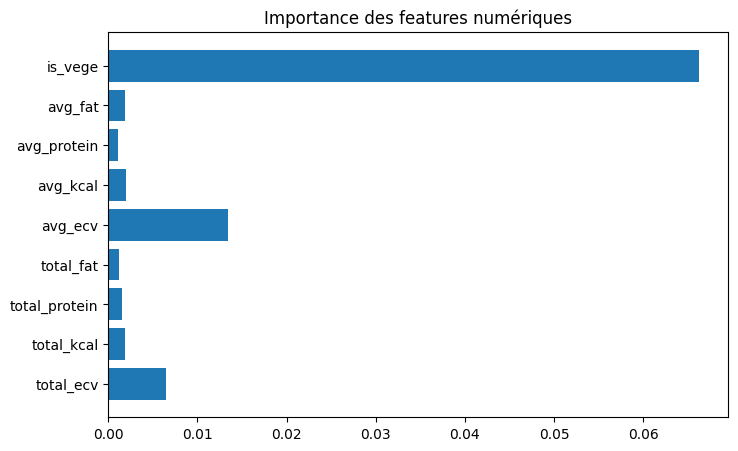

In [ ]:
plt.figure(figsize=(8,5))
plt.barh(numeric_features, model_xgb.feature_importances_[-len(numeric_features):])
plt.title("Importance des features numériques")
plt.show()